## Audio Weather Classification Script

This script is designed to perform audio classification using convolutional neural networks (CNNs). It loads audio files from the specified directory, preprocesses them by converting them to mel spectrograms, pads them to ensure uniform dimensions, and then trains a CNN model for classifying the audio into different classes.

### Steps:
1. **Data Loading and Preprocessing**: Audio files are loaded from the specified directory (`path`) and converted to mel spectrograms using the Librosa library. The spectrograms are then padded to ensure uniform dimensions.

2. **Data Splitting**: The preprocessed data is split into training and testing sets using a specified test size.

3. **Model Architecture**: The CNN model architecture consists of two convolutional layers followed by max-pooling layers and dropout regularization. The output is passed through fully connected layers with ReLU activation functions, and a softmax activation function is used for multi-class classification.

4. **Training**: The model is trained using the training data, and the training progress is monitored using accuracy and loss metrics.

### Libraries Used:
- Librosa: For audio processing
- NumPy: For numerical operations
- TensorFlow and Keras: For building and training the CNN model
- Scikit-learn: For data preprocessing and splitting
- Joblib for multiple thread procsssing 

Feel free to modify the script and experiment with different parameters to improve model performance.

### Import Libraries

In [4]:
import os
import librosa
#import librosa.display
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from IPython.display import Audio
import joblib

### Data Preprocessing

In [5]:
# Created a class to contain the data storage loading and spectogram creation 
# this is done in order to simpllfy the handling of data and vriables in dealing with multiple threads with out
# having to use multiple segements haded to each call of the function 


class WeatherData:

    # number of parallel jobs to run
    n_jobs = 12
    # alters level of feed back from parallel workers 
    verbose = 5
    target_length=216
    # class labels 
    class_labels =  ["Rain", "Thunder","Earthquake", "Flood" , "Tornado", "Volcano"] # Class names ("Rain", "Thunder", "Earthquake", "Flood" , "Tornado", "Volcano")
    # change to suit where the data is stored 
    path = r'D:\Weather_Sounds\Weather_sounds'

    audios = []
    labels = []
    mel_spectrograms = []
    audio_to_process= []
    

    

# defualt initilisation function for the class 
    def __init__(_path = r'D:\Weather_Sounds\Weather_sounds', _n_jobs =8, _class_labels = ["Rain", "Thunder"],_target_length=216  ):
        path = _path
        n_jobs=_n_jobs
        class_labels = _class_labels




    def load_and_pad_audio(self,file_path):
        # Load audio file
        audio, sr = librosa.load(file_path, sr=None)
        
        # Calculate the number of required samples
        required_samples = int(self.target_length * sr / 10.0)

        if len(audio) < required_samples:
            # Pad audio if it is too short
            audio = np.pad(audio, (0, max(0, required_samples - len(audio))), "constant")
        else:
            # Truncate audio if it is too long
            audio = audio[:required_samples]
        
        return audio, sr

    def load_audio_files(self):
        i = 0
        files_to_load = []
        length =0

    # iterate through lables 
        for label in self.class_labels:
            # create label class path
            class_path =(os.path.join(self.path, label))
            # here we are creatinga length property for the list that will hold the samples and the the rate as the parrallel
            #function wil need to have have all data toiterate before starting and need to pre set the list length so as to have relevent data 
            # stored in the appropraite index  rather than relying on the order as differnet threads may finish at differnet times reltive to their start   
            length += len(os.listdir(class_path))
            files_to_load.append(os.listdir(class_path))
        self.audio_to_process = [[] for i in range(length)]
        self.mel_spectrograms = [None]*length
        
        for label in self.class_labels:
            # Path to the folder containing audio files of a specific label
            class_path = os.path.join(self.path, label)
            audio = None

            # load data to the lists 
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                audio, sr = self.load_and_pad_audio(file_path)
                self.audio_to_process[i].append(audio)
                self.audio_to_process[i].append(sr)
                self.audio_to_process[i].append(label)
                #self.labels.append(label)
                
                i+=1

            print(len(self.audio_to_process))
            
            




# Function for creating the specogram usaing the index of the passed list item 
    def create_spectrogram(self,audio):
        
        output = librosa.feature.melspectrogram(y=audio[0], sr=audio[1], n_mels=128)

        return output,audio[2]
        
        
# parallel function using the 
    def parallel_Spectogram(self):
            # joblib libarary allows  for the allocation of worker threads to carry out the spectogram creation based on the for loop of the range of data samples 
            output = joblib.Parallel(n_jobs=self.n_jobs,verbose=self.verbose,prefer="threads")(joblib.delayed(self.create_spectrogram)(self.audio_to_process[i]) for i in range(len(self.audio_to_process)))
                
            for items in output:
                log_mel_spectrogram = librosa.power_to_db(items[0])
                self.audios.append(log_mel_spectrogram)
                self.labels.append(items[1])

            
# functioin to plot the spectograms 
    def plot_mel_spectrogram_full(self,mel_spectrogram):
        fig = plt.figure()
        ax = fig.add_subplot(111)

        plt.title("Log Mel Spectrogram of Audio")    
        img = librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max),
                                    x_axis='time',  y_axis='mel', hop_length = 128, fmax=8000)
        fig.colorbar(img, ax=ax, format=f'%0.2f dB')
        plt.show()

        




In [6]:
# create weather data instance 
weatherData =  WeatherData()
weatherData.__init__()
# call the load function 
weatherData.load_audio_files()

3672
3672


In [7]:
# create the spectograms 
weatherData.parallel_Spectogram()

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    8.4s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:   13.5s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   20.3s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:   27.6s
[Parallel(n_jobs=12)]: Done 858 tasks      | elapsed:   37.1s
[Parallel(n_jobs=12)]: Done 1128 tasks      | elapsed:   47.5s
[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 2154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 2568 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 3018 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 3504 tasks      | elapsed:  2.4min
[Parallel(n_jobs=12)]: Done 3672 out of 3672 | elapsed:  2.5min finished


In [8]:


audios = weatherData.audios
labels = weatherData.labels
# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Finding max dimensions for padding
max_length = max(audio.shape[1] for audio in audios)
max_height = max(audio.shape[0] for audio in audios)

# Pad spectrograms to the max dimensions
audios_padded = np.array([np.pad(audio, ((0, max_height - audio.shape[0]), (0, max_length - audio.shape[1])), 'constant') for audio in audios])

# Reshape for CNN input
audios_array = audios_padded.reshape(audios_padded.shape[0], audios_padded.shape[1], audios_padded.shape[2], 1)


In [9]:
print(audios_array.shape)
print(labels_categorical.shape)

(3672, 128, 1861, 1)
(3672, 2)


In [10]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(audios_array, labels_categorical, test_size=0.2, random_state=42)

### Building Model

In [11]:
def build_model(input_shape, num_classes):
    model = Sequential()
    
    # First conv block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Second conv block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
92/92 [==============================] - 865s 9s/step - loss: 3.9976 - accuracy: 0.9918 - val_loss: 4335.3418 - val_accuracy: 0.5524


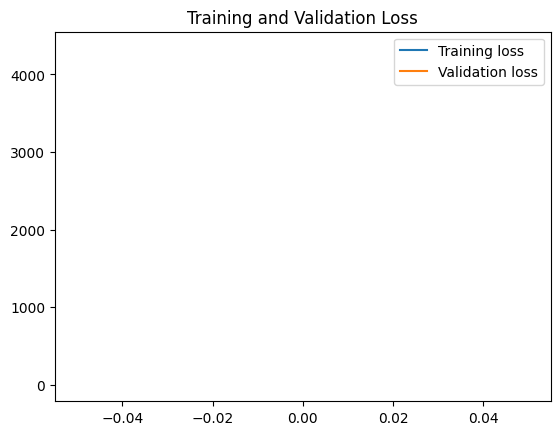

In [12]:
# This call is for the TF distrubute library that allows for mirroring of task on multiple systems in this case accross multipple GPU's 
strategy = tf.distribute.MirroredStrategy()

# allow for running of the the mosel tranning under the chosen  stratergy 
with strategy.scope():
    model = build_model(input_shape=(X_train.shape[1], X_train.shape[2], 1), num_classes=len(weatherData.class_labels))

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=5)
    
    import matplotlib.pyplot as plt
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [16]:
print(history.history)


{'loss': [3.9975943565368652], 'accuracy': [0.9918283820152283], 'val_loss': [4335.341796875], 'val_accuracy': [0.5523809790611267]}


### Training Model

### Analysis

#### Saving Model

In [13]:
# Define the path to save the model PB format
model_dir = "weather_audio_detection_model"

# Save the model in SavedModel format
tf.saved_model.save(model, model_dir)

INFO:tensorflow:Assets written to: weather_audio_detection_model\assets


INFO:tensorflow:Assets written to: weather_audio_detection_model\assets


In [14]:
# Save model in h5 format
model.save('WeatherAudioDetectionModel.h5')